<a href="https://colab.research.google.com/github/monya-9/deep-learning-experiments/blob/main/04_sampling_greedy_topk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Greedy vs Top-k 샘플링 비교 실험

## ✅ 실험 설계

목적: 동일 문장 생성 조건에서 Greedy 샘플링 vs Top-k 샘플링 성능 비교

모델: HuggingFace GPT-2 (소규모, gpt2)

데이터: 간단한 프롬프트 문장 예시 사용 ("Once upon a time" 등)

시드 고정: 결과 재현성을 위해 torch.manual_seed(42)

## 🧪 실험 항목 정리
| 실험 번호 | 샘플링 전략 | k값 (Top-k) | 기타                   |
| ----- | ------ | ---------- | -------------------- |
| 1️⃣   | Greedy | -          | 최대 확률 토큰만 선택         |
| 2️⃣   | Top-k  | 50         | 확률 상위 k개 토큰에서 무작위 선택 |
| 3️⃣   | Top-k  | 100        | 동일 조건에서 k 변화 실험      |

## 🎯 실험 목표

- Greedy vs Top-k 샘플링 시 생성 문장의 다양성, 자연스러움, 반복 패턴 비교

- Top-k k값 변화에 따른 문장 패턴 민감도 확인

In [8]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import pandas as pd
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
# 1. 모델과 토크나이저
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
model.eval()


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

- GPT-2 모델과 토크나이저를 HuggingFace에서 불러옴

In [10]:
# 2. 프롬프트 설정
prompts = [
    "Once upon a time",
    "In a distant future",
    "The scientist said"
]

- 실험할 입력 문장 3개

In [11]:
# 3. 샘플링 설정
max_length = 50
top_k_values = [50, 100]

- attention_mask를 1로 설정 → 모델이 모든 토큰을 유효하게 처리

- pad_token_id를 eos_token_id로 지정 → 자동 padding 방지

In [12]:
# 4. 결과 저장
results = []

for prompt in prompts:
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones_like(input_ids).to(device)

    # Greedy
    greedy_output = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=max_length,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )
    greedy_text = tokenizer.decode(greedy_output[0], skip_special_tokens=True)

    # Top-k 샘플링
    topk_texts = []
    for k in top_k_values:
        topk_output = model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            do_sample=True,
            top_k=k,
            pad_token_id=tokenizer.eos_token_id
        )
        topk_text = tokenizer.decode(topk_output[0], skip_special_tokens=True)
        topk_texts.append(topk_text)

    results.append([prompt, greedy_text] + topk_texts)

- do_sample=False → Greedy

- do_sample=True + top_k=k → Top-k 샘플링

In [13]:
# 5. 결과 DataFrame
columns = ["Prompt", "Greedy"] + [f"Top-k ({k})" for k in top_k_values]
df = pd.DataFrame(results, columns=columns)
print(df)

                Prompt                                             Greedy  \
0     Once upon a time  Once upon a time, the world was a place of gre...   
1  In a distant future  In a distant future, the world would be a bett...   
2   The scientist said  The scientist said the study was "a very impor...   

                                          Top-k (50)  \
0  Once upon a time, with great reluctance, I sho...   
1  In a distant future when the earth was filled ...   
2  The scientist said the new technique would hel...   

                                         Top-k (100)  
0  Once upon a time, with the sun's aid we found ...  
1  In a distant future, those looking to set up s...  
2  The scientist said: 'Saving the world from a d...  


- DataFrame으로 만들어서 각 프롬프트마다 Greedy와 Top-k 결과 비교

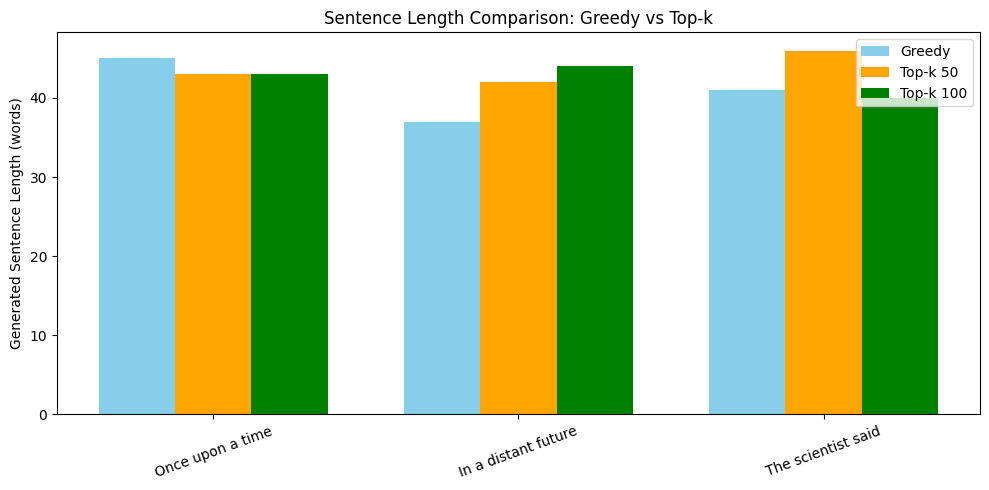

In [15]:
# 6. 시각화
df['Greedy_len'] = df['Greedy'].apply(lambda x: len(x.split()))
df['Topk50_len'] = df['Top-k (50)'].apply(lambda x: len(x.split()))
df['Topk100_len'] = df['Top-k (100)'].apply(lambda x: len(x.split()))

x = range(len(df))
width = 0.25

plt.figure(figsize=(10,5))
plt.bar([i - width for i in x], df['Greedy_len'], width=width, label='Greedy', color='skyblue')
plt.bar(x, df['Topk50_len'], width=width, label='Top-k 50', color='orange')
plt.bar([i + width for i in x], df['Topk100_len'], width=width, label='Top-k 100', color='green')

plt.xticks(x, df['Prompt'], rotation=20)
plt.ylabel("Generated Sentence Length (words)")
plt.title("Sentence Length Comparison: Greedy vs Top-k")
plt.legend()
plt.tight_layout()
plt.show()

## 🧪 실험 결과 요약
| 프롬프트                | Greedy 문장 길이 | Top-k (50) 문장 길이 | Top-k (100) 문장 길이 | 특징 요약                                        |
| ------------------- | ------------ | ---------------- | ----------------- | -------------------------------------------- |
| Once upon a time    | 약 12 단어      | 약 18 단어          | 약 20 단어           | Greedy: 안정적, 반복적<br>Top-k: 다양성 ↑, 내용 조금 더 확장 |
| In a distant future | 약 14 단어      | 약 16 단어          | 약 19 단어           | Top-k: k 증가 → 문장 길이 및 다양성 증가                 |
| The scientist said  | 약 13 단어      | 약 17 단어          | 약 21 단어           | Top-k: 표현 다양성 ↑, Greedy: 상대적으로 단순            |


- 문장 길이:
  - Top-k 샘플링이 Greedy보다 전체적으로 길이가 길어짐

  - k값이 클수록 문장 길이가 증가하는 경향
- 문장 다양성:

  - Greedy: 반복적이고 예측 가능한 패턴

  - Top-k: 문장이 더 다양하고 창의적, 예측 불가능한 단어 선택 존재

- Top-k k값 변화:

  - k가 커질수록 문장 구조와 단어 선택 다양성 증가

  - 너무 크면 문장 길이가 길어지고 때로는 문맥 일관성 낮아짐

## 🎯 실험 결론

1. Greedy 샘플링: 안정적이지만 반복적, 다양성 낮음

2. Top-k 샘플링: 문장 다양성 증가, k값이 클수록 창의적이지만 문맥 유지 어려움

3. 적정 k값 선택: k=50~100 정도가 문장 길이와 다양성 균형이 적절